In [1]:
# Import basic libraries
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
import os
import PIL
import PIL.Image

# Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
folder_path = 'D:\\Study\\DataScience\\GeoAI\\ImageClassification\\ImageSegmentation\\landcover'

# Load images and masks as X and y
def load_images_masks_from_folder(folder):
    
    # Image Path
    image_path = os.path.join(folder, 'images')
    
    list_of_images = []
    for root, d_names, i_names in os.walk(image_path):
        for i in i_names:
            list_of_images.append(os.path.join(root, i))
    
    # Masks Path
    mask_path = os.path.join(folder, 'masks')
    
    list_of_masks = []
    for root, d_names, m_names in os.walk(mask_path):
        for m in m_names:
            list_of_masks.append(os.path.join(root, m))
    
    
    # Read Images
    images = []
    for image in list_of_images:
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        
        #img = cv2.resize(img, (128, 128, 3))
        images.append(img)
    
    # Read Masks
    masks = []
    for mask in list_of_masks:
        msk = np.asarray(PIL.Image.open(mask))
        
        #msk = cv2.resize(msk, (128, 128, 1))
        masks.append(msk)
    
    return images, masks

In [3]:
X, y = load_images_masks_from_folder(folder_path)

In [4]:
# Convert list into numpy arrays
X = np.asarray(X)
y = np.asarray(y)

In [5]:
# The shape of X array should be : (N, H, W, C), where
# N - Number of images,
# H - Height of the image
# W - Width of the image
# C - Channels in the image


# The shape of the y array should be : (N, H, W, 1)
#y = y.reshape((y.shape[0], y.shape[1], y.shape[2], 1))
y = np.asarray(y).reshape((36, 128, 128, 1))

In [6]:
# Split the data into training and testing datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 0)

# Print the shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(28, 128, 128, 3)
(28, 128, 128, 1)
(8, 128, 128, 3)
(8, 128, 128, 1)


In [7]:
# Import the modules required for image segmentation
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss, CategoricalCELoss
from segmentation_models.metrics import iou_score

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [47]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Define Classes
CLASSES = ['building', 'road', 'grass']
class_values = [CLASSES.index(cls.lower()) for cls in CLASSES]
#class_values.insert(len(class_values), 0)

# Preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Reshape mask shape to (N, H, W, Number of classes+background) > (N, 128, 128, 4)
m_train = [(y_train == v) for v in class_values]
m_train = np.stack(m_train, axis=-1).astype('float')
#m_train = np.asarray(m_train).reshape((y_train.shape[0], 128, 128, 4))

# add background if mask is not binary
if m_train.shape[-1] != 1:
    background = 1 - m_train.sum(axis=-1, keepdims=True)
    m_train = np.concatenate((m_train, background), axis=-1)

# Squeeze shape from (N, 128, 128, 1, 4) to (N, 128, 128, 4)
m_train = m_train.squeeze()    
    
m_test = [(y_test == v) for v in class_values]
m_test = np.stack(m_test, axis=-1).astype('float')
#m_test = np.asarray(m_test).reshape((y_test.shape[0], 128, 128, 4))

# add background if mask is not binary
if m_test.shape[-1] != 1:
    background = 1 - m_test.sum(axis=-1, keepdims=True)
    m_test = np.concatenate((m_test, background), axis=-1)

# Squeeze shape from (N, 128, 128, 1, 4) to (N, 128, 128, 4)
m_test = m_test.squeeze()      
    
# Define model parameters
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (building: 1.; road: 2.; grass: 3.; background: 0.5;)
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 3, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Define model
model = sm.Unet(BACKBONE, encoder_weights = 'imagenet', classes = n_classes, activation = activation)
model.compile('Adam', loss = total_loss, metrics = metrics)

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [EarlyStopping(patience=5, verbose=1), ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('vgg_unet_lossfn.h5', verbose=1, save_best_only=True)]

# Fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(x=X_train, y=m_train, batch_size=1, callbacks=callbacks, epochs=100, validation_data=(X_test, m_test))

Train on 28 samples, validate on 8 samples
Epoch 1/100
28/28 [==============================] - 34s 1s/step - loss: 0.6559 - iou_score: 0.1763 - f1-score: 0.2538 - val_loss: 1.2038 - val_iou_score: 0.2774 - val_f1-score: 0.3130

Epoch 00001: val_loss improved from inf to 1.20382, saving model to vgg_unet_lossfn.h5
Epoch 2/100
28/28 [==============================] - 34s 1s/step - loss: 0.5032 - iou_score: 0.2748 - f1-score: 0.3737 - val_loss: 0.9347 - val_iou_score: 0.2747 - val_f1-score: 0.3316

Epoch 00002: val_loss improved from 1.20382 to 0.93473, saving model to vgg_unet_lossfn.h5
Epoch 3/100
28/28 [==============================] - 32s 1s/step - loss: 0.3994 - iou_score: 0.3781 - f1-score: 0.4945 - val_loss: 1.0105 - val_iou_score: 0.2846 - val_f1-score: 0.3251

Epoch 00003: val_loss did not improve from 0.93473
Epoch 4/100
28/28 [==============================] - 34s 1s/step - loss: 0.3991 - iou_score: 0.3805 - f1-score: 0.4927 - val_loss: 0.8831 - val_iou_score: 0.3358 - val_f1

Text(0.5, 1.0, 'Accuracy Curves')

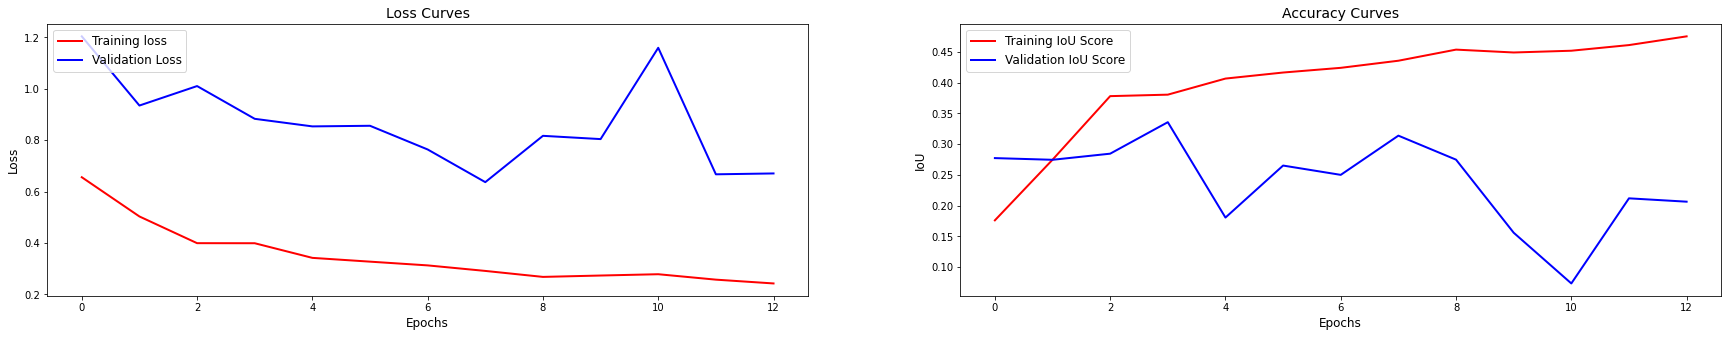

In [48]:
# Visualize Loss Curves
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['loss'],'r', linewidth=2.0)
plt.plot(history.history['val_loss'],'b', linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=12, loc='upper left')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curves', fontsize=14)
  
# Visualize IoU Curves
plt.subplot(122)
plt.plot(history.history['iou_score'], 'r', linewidth=2.0)
plt.plot(history.history['val_iou_score'], 'b', linewidth=2.0)
plt.legend(['Training IoU Score', 'Validation IoU Score'], fontsize=12, loc='upper left')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('IoU', fontsize=12)
plt.title('Accuracy Curves', fontsize=14)